In [1]:
# Introduction

# In this project, we’ll explore whether there is a significant difference in conversion between two groups (A and B) using A/B testing.
# The data comes from a simulated website experiment where users were randomly shown one of two landing pages.
# Using Python and statistical testing, we’ll compare conversion rates between both groups to determine if one version performs significantly better than the other.


In [2]:
# Import the libraries.

import pandas as pd
import zipfile
import kaggle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest

In [3]:
# Download the dataset "Wine Reviews" from Kaggle, it will download a zip file.

!kaggle datasets download -d zhangluyuan/ab-testing

Dataset URL: https://www.kaggle.com/datasets/zhangluyuan/ab-testing
License(s): unknown
ab-testing.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
# Extract the content from the zip file.

zipfile_name = 'ab-testing.zip'
with zipfile.ZipFile(zipfile_name, 'r') as file:
    file.extractall()

In [5]:
# Read in the csv as a pandas dataframe.

df = pd.read_csv('ab_data.csv')

In [6]:
# Explore the data (part 1). 
# As far as we can see, the dataframe contains the following columns: user_id, timestamp, group, landing_page, converted.

df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [7]:
# Explore the data (part 2).
# There are no missing values, all columns have the same number of entries, and both user_id and converted are integers. The timestamp, group, and landing_page columns are currently of type object.

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [8]:
# Align groups to their specific landing pages.

df_clean = df[
    ((df['group'] == 'control') & (df['landing_page'] == 'old_page')) |
    ((df['group'] == 'treatment') & (df['landing_page'] == 'new_page'))
]

In [9]:
# Count the number of occurrences of each group.

total_counts = df_clean.groupby('group')['converted'].count()
print(total_counts)

group
control      145274
treatment    145311
Name: converted, dtype: int64


In [10]:
# Count the number of users converted (1) with method sum.

conversion_counts = df_clean.groupby('group')['converted'].sum()

In [11]:
print(conversion_counts)

group
control      17489
treatment    17264
Name: converted, dtype: int64


In [12]:
# Interpretation:
# The p-value of 0.1897 is greater than the significance level of 0.05,
# so we fail to reject the null hypothesis. This suggests that the
# observed difference in conversion rates between groups A and B is not statistically significant.

# The z-statistic of 1.312 falls within the range of expected random variation
# under the null hypothesis and does not indicate a strong deviation.

z_stat, p_val = proportions_ztest(count=conversion_counts.values, nobs=total_counts.values)
print(f"Z-statistic: {z_stat:.3f}")
print(f"P-value: {p_val:.4f}")

Z-statistic: 1.312
P-value: 0.1897


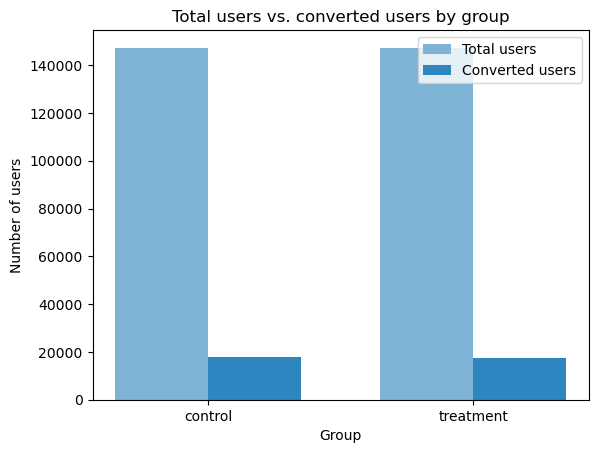

In [13]:
# Count users per group.
group_counts = df['group'].value_counts().sort_index()
conversion_counts = df[df['converted'] == 1]['group'].value_counts().sort_index()

# Creat positions in X axis per bar.
x = np.arange(len(group_counts))  # [0, 1] for A and B groups
width = 0.35  # Width for each bar

# Graph bars
fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, group_counts.values, width, label='Total users', color='#7FB3D5')     
bars2 = ax.bar(x + width/2, conversion_counts.values, width, label='Converted users', color='#2E86C1')  

# Labels and ticks
ax.set_xticks(x)
ax.set_xticklabels(group_counts.index)
ax.set_xlabel('Group')
ax.set_ylabel('Number of users')
ax.set_title('Total users vs. converted users by group')
ax.legend()

plt.show()

In [14]:
# Conclusion

# The Z-statistic and p-value indicate that the new page does not show a significant difference in conversion compared to the old page.
# In this case, it might be helpful to explore a different page design and run another A/B test to evaluate its effectiveness.